In [2]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
# # Transformação: converte para tensor e normaliza (média e desvio de MNIST)
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

# # Dataset de treino e teste
# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# # Subset com os primeiros 1000 para treino e 500 para validação
# train_subset = Subset(train_dataset, range(1000))
# val_subset   = Subset(test_dataset, range(500))

# # DataLoaders
# train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
# val_loader   = DataLoader(val_subset, batch_size=64, shuffle=False)

In [4]:
# Transformação padrão para Fashion-MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

# Dataset Fashion-MNIST
full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
full_val_dataset   = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Subsets reduzidos
train_subset = Subset(full_train_dataset, range(200))
val_subset   = Subset(full_val_dataset, range(200))

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:10<00:00, 2.55MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 109kB/s]
100%|██████████| 4.42M/4.42M [00:08<00:00, 539kB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.8MB/s]


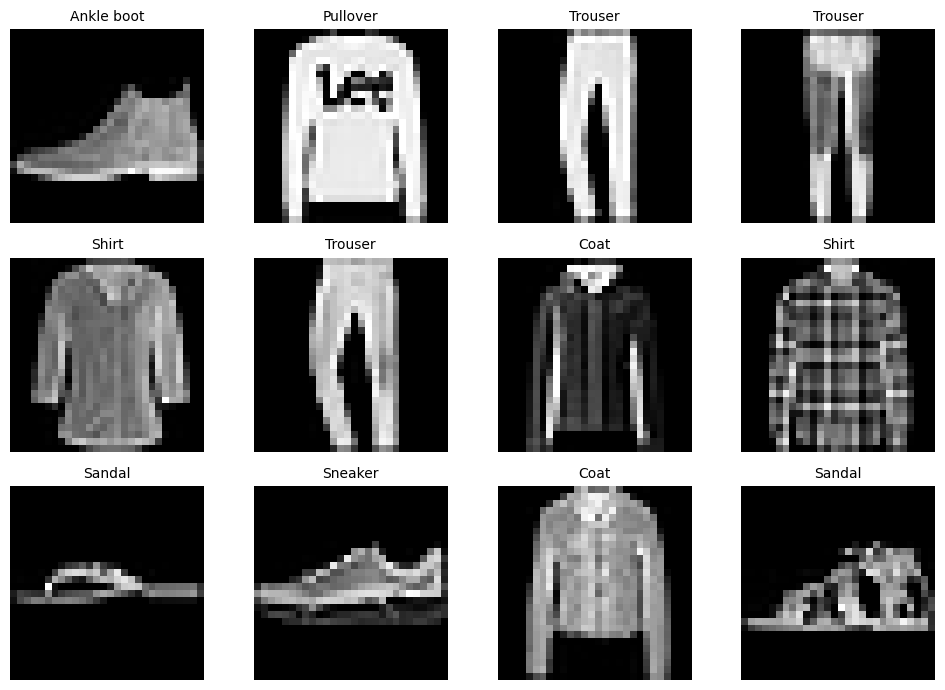

In [5]:
# Classe names
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Mostrar 12 imagens
fig, axes = plt.subplots(3, 4, figsize=(10, 7))
for i, ax in enumerate(axes.flatten()):
    img, label = val_subset[i]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(class_names[label], fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [6]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }
    
    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')
        
        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def plot_training_history(history):
    epochs = range(1, len(history['train_losses']) + 1)
    
    plt.figure(figsize=(12, 5))

    # Losses
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.plot(epochs, history['train_losses'], label='Train Loss')
    plt.plot(epochs, history['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracies
    plt.subplot(1, 2, 2)
    plt.grid()
    plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 14.69it/s]


Epoch 1, Train Loss: 2.301, Train Accuracy: 13.50%
Epoch 1, Val Loss: 2.311, Val Accuracy: 14.50%


100%|██████████| 4/4 [00:00<00:00, 51.62it/s]


Epoch 2, Train Loss: 2.293, Train Accuracy: 22.00%
Epoch 2, Val Loss: 2.289, Val Accuracy: 26.00%


100%|██████████| 4/4 [00:00<00:00, 69.05it/s]


Epoch 3, Train Loss: 2.259, Train Accuracy: 30.00%
Epoch 3, Val Loss: 2.260, Val Accuracy: 26.50%


100%|██████████| 4/4 [00:00<00:00, 68.39it/s]

Epoch 4, Train Loss: 2.251, Train Accuracy: 21.50%


Epoch 4, Val Loss: 2.219, Val Accuracy: 15.50%


100%|██████████| 4/4 [00:00<00:00, 68.75it/s]


Epoch 5, Train Loss: 2.189, Train Accuracy: 16.00%
Epoch 5, Val Loss: 2.181, Val Accuracy: 16.00%


100%|██████████| 4/4 [00:00<00:00, 66.17it/s]

Epoch 6, Train Loss: 2.187, Train Accuracy: 18.00%


Epoch 6, Val Loss: 2.115, Val Accuracy: 28.00%


100%|██████████| 4/4 [00:00<00:00, 71.61it/s]


Epoch 7, Train Loss: 2.013, Train Accuracy: 30.00%
Epoch 7, Val Loss: 2.013, Val Accuracy: 33.00%


100%|██████████| 4/4 [00:00<00:00, 67.73it/s]

Epoch 8, Train Loss: 1.841, Train Accuracy: 36.00%


Epoch 8, Val Loss: 1.843, Val Accuracy: 32.00%


100%|██████████| 4/4 [00:00<00:00, 65.92it/s]


Epoch 9, Train Loss: 1.578, Train Accuracy: 39.50%
Epoch 9, Val Loss: 1.628, Val Accuracy: 42.50%


100%|██████████| 4/4 [00:00<00:00, 67.54it/s]

Epoch 10, Train Loss: 1.358, Train Accuracy: 50.50%


Epoch 10, Val Loss: 1.453, Val Accuracy: 54.00%


100%|██████████| 4/4 [00:00<00:00, 67.96it/s]


Epoch 11, Train Loss: 1.249, Train Accuracy: 52.50%
Epoch 11, Val Loss: 1.592, Val Accuracy: 43.00%


100%|██████████| 4/4 [00:00<00:00, 66.74it/s]

Epoch 12, Train Loss: 1.367, Train Accuracy: 48.50%


Epoch 12, Val Loss: 1.440, Val Accuracy: 53.00%


100%|██████████| 4/4 [00:00<00:00, 75.62it/s]


Epoch 13, Train Loss: 1.158, Train Accuracy: 55.50%
Epoch 13, Val Loss: 1.438, Val Accuracy: 56.00%


100%|██████████| 4/4 [00:00<00:00, 45.97it/s]

Epoch 14, Train Loss: 1.038, Train Accuracy: 63.50%


Epoch 14, Val Loss: 1.197, Val Accuracy: 58.50%


100%|██████████| 4/4 [00:00<00:00, 58.46it/s]


Epoch 15, Train Loss: 1.160, Train Accuracy: 60.50%
Epoch 15, Val Loss: 1.080, Val Accuracy: 66.00%


100%|██████████| 4/4 [00:00<00:00, 47.74it/s]


Epoch 16, Train Loss: 1.052, Train Accuracy: 67.00%
Epoch 16, Val Loss: 1.103, Val Accuracy: 63.00%


100%|██████████| 4/4 [00:00<00:00, 59.44it/s]


Epoch 17, Train Loss: 0.873, Train Accuracy: 71.50%
Epoch 17, Val Loss: 1.113, Val Accuracy: 52.00%


100%|██████████| 4/4 [00:00<00:00, 67.54it/s]

Epoch 18, Train Loss: 0.790, Train Accuracy: 65.00%


Epoch 18, Val Loss: 0.903, Val Accuracy: 64.50%


100%|██████████| 4/4 [00:00<00:00, 61.21it/s]


Epoch 19, Train Loss: 0.861, Train Accuracy: 73.00%
Epoch 19, Val Loss: 0.906, Val Accuracy: 70.00%


100%|██████████| 4/4 [00:00<00:00, 65.87it/s]

Epoch 20, Train Loss: 0.742, Train Accuracy: 72.00%


Epoch 20, Val Loss: 0.868, Val Accuracy: 69.50%
Treinamento concluído


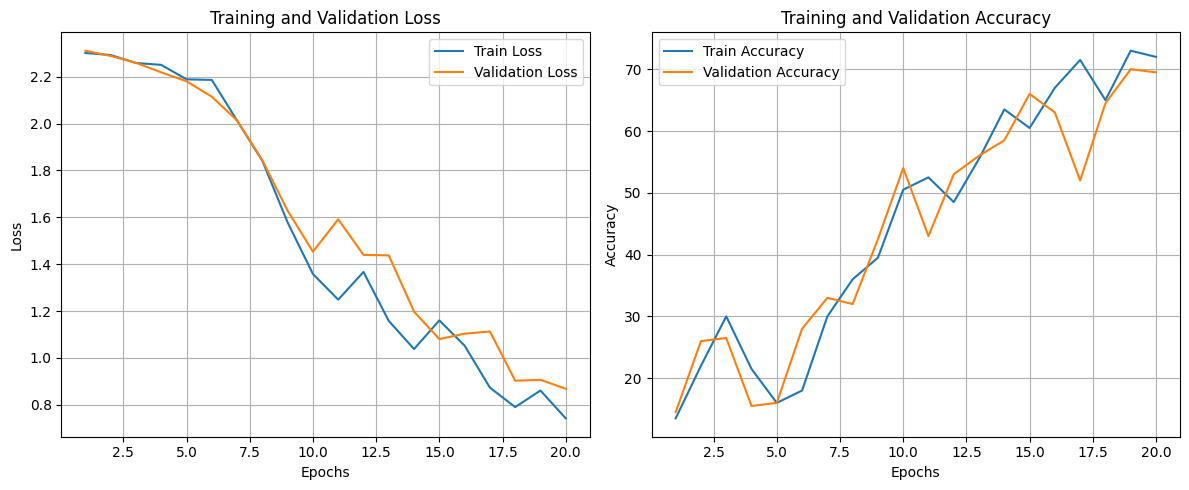

Acurácia da rede na base de teste: 69.50%


In [8]:
model_1 = CNN(
    initialize_weights=False,
    dropout=0.0
)

criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9)

# Treinando a CNN
history_1 = train_model(
    model=model_1,
    trainloader=train_loader,
    valloader=val_loader,
    criterion=criterion_1,
    optimizer=optimizer_1,
    num_epochs=20
)

plot_training_history(history_1)

test_model(model_1, val_loader)

100%|██████████| 4/4 [00:00<00:00, 43.64it/s]


Epoch 1, Train Loss: 2.417, Train Accuracy: 13.00%
Epoch 1, Val Loss: 2.280, Val Accuracy: 16.50%


100%|██████████| 4/4 [00:00<00:00, 23.03it/s]


Epoch 2, Train Loss: 2.331, Train Accuracy: 15.00%
Epoch 2, Val Loss: 2.230, Val Accuracy: 22.50%


100%|██████████| 4/4 [00:00<00:00, 18.59it/s]


Epoch 3, Train Loss: 2.217, Train Accuracy: 20.50%
Epoch 3, Val Loss: 2.186, Val Accuracy: 22.50%


100%|██████████| 4/4 [00:00<00:00, 37.55it/s]


Epoch 4, Train Loss: 2.133, Train Accuracy: 26.00%
Epoch 4, Val Loss: 2.109, Val Accuracy: 21.50%


100%|██████████| 4/4 [00:00<00:00, 32.86it/s]

Epoch 5, Train Loss: 2.116, Train Accuracy: 26.00%


Epoch 5, Val Loss: 1.988, Val Accuracy: 25.50%


100%|██████████| 4/4 [00:00<00:00, 30.08it/s]

Epoch 6, Train Loss: 1.937, Train Accuracy: 30.00%


Epoch 6, Val Loss: 1.892, Val Accuracy: 35.00%


100%|██████████| 4/4 [00:00<00:00, 34.95it/s]

Epoch 7, Train Loss: 1.889, Train Accuracy: 28.50%
Epoch 7, Val Loss: 1.744, Val Accuracy: 42.50%



100%|██████████| 4/4 [00:00<00:00, 29.74it/s]


Epoch 8, Train Loss: 1.794, Train Accuracy: 36.00%
Epoch 8, Val Loss: 1.621, Val Accuracy: 50.50%


100%|██████████| 4/4 [00:00<00:00, 46.40it/s]


Epoch 9, Train Loss: 1.548, Train Accuracy: 47.50%
Epoch 9, Val Loss: 1.492, Val Accuracy: 54.50%


100%|██████████| 4/4 [00:00<00:00, 28.93it/s]

Epoch 10, Train Loss: 1.626, Train Accuracy: 45.50%


Epoch 10, Val Loss: 1.291, Val Accuracy: 62.50%


100%|██████████| 4/4 [00:00<00:00, 36.25it/s]


Epoch 11, Train Loss: 1.643, Train Accuracy: 49.00%
Epoch 11, Val Loss: 1.209, Val Accuracy: 67.00%


100%|██████████| 4/4 [00:00<00:00, 46.94it/s]


Epoch 12, Train Loss: 1.190, Train Accuracy: 60.00%
Epoch 12, Val Loss: 1.206, Val Accuracy: 68.50%


100%|██████████| 4/4 [00:00<00:00, 23.44it/s]

Epoch 13, Train Loss: 1.200, Train Accuracy: 59.50%


Epoch 13, Val Loss: 1.056, Val Accuracy: 68.50%


100%|██████████| 4/4 [00:00<00:00, 29.07it/s]

Epoch 14, Train Loss: 1.237, Train Accuracy: 54.50%


Epoch 14, Val Loss: 0.948, Val Accuracy: 66.00%


100%|██████████| 4/4 [00:00<00:00, 43.65it/s]


Epoch 15, Train Loss: 1.056, Train Accuracy: 64.00%
Epoch 15, Val Loss: 0.893, Val Accuracy: 71.00%


100%|██████████| 4/4 [00:00<00:00, 35.30it/s]


Epoch 16, Train Loss: 0.883, Train Accuracy: 65.50%
Epoch 16, Val Loss: 0.896, Val Accuracy: 72.00%


100%|██████████| 4/4 [00:00<00:00, 34.59it/s]

Epoch 17, Train Loss: 0.794, Train Accuracy: 68.00%


Epoch 17, Val Loss: 0.872, Val Accuracy: 69.50%


100%|██████████| 4/4 [00:00<00:00, 33.33it/s]

Epoch 18, Train Loss: 0.955, Train Accuracy: 69.50%


Epoch 18, Val Loss: 0.918, Val Accuracy: 69.00%


100%|██████████| 4/4 [00:00<00:00, 22.85it/s]

Epoch 19, Train Loss: 0.737, Train Accuracy: 69.50%


Epoch 19, Val Loss: 0.817, Val Accuracy: 71.00%


100%|██████████| 4/4 [00:00<00:00, 27.48it/s]

Epoch 20, Train Loss: 0.773, Train Accuracy: 70.50%


Epoch 20, Val Loss: 0.778, Val Accuracy: 71.50%
Treinamento concluído


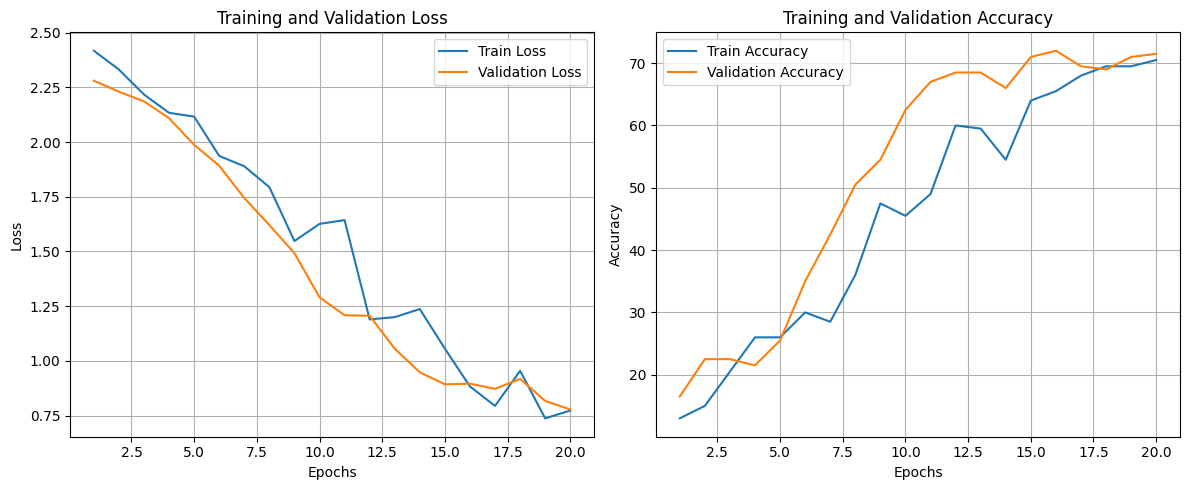

Acurácia da rede na base de teste: 71.50%


In [9]:
model_2 = CNN(
    initialize_weights=True,
    dropout=0.5
)

criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)

# Treinando a CNN
history_2 = train_model(
    model=model_2,
    trainloader=train_loader,
    valloader=val_loader,
    criterion=criterion_2,
    optimizer=optimizer_2,
    num_epochs=20
)

plot_training_history(history_2)

test_model(model_2, val_loader)

## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.


Treinando modelo: conv1_out=6, conv2_out=12


100%|██████████| 4/4 [00:00<00:00, 41.02it/s]


Epoch 1, Train Loss: 2.373, Train Accuracy: 10.50%
Epoch 1, Val Loss: 2.246, Val Accuracy: 15.50%


100%|██████████| 4/4 [00:00<00:00, 22.30it/s]


Epoch 2, Train Loss: 2.248, Train Accuracy: 13.50%
Epoch 2, Val Loss: 2.213, Val Accuracy: 16.00%


100%|██████████| 4/4 [00:00<00:00, 58.42it/s]


Epoch 3, Train Loss: 2.247, Train Accuracy: 15.50%
Epoch 3, Val Loss: 2.146, Val Accuracy: 25.50%


100%|██████████| 4/4 [00:00<00:00, 34.60it/s]


Epoch 4, Train Loss: 2.106, Train Accuracy: 23.00%
Epoch 4, Val Loss: 2.092, Val Accuracy: 36.50%


100%|██████████| 4/4 [00:00<00:00, 33.90it/s]


Epoch 5, Train Loss: 2.014, Train Accuracy: 27.50%
Epoch 5, Val Loss: 1.959, Val Accuracy: 33.00%


100%|██████████| 4/4 [00:00<00:00, 48.77it/s]


Epoch 6, Train Loss: 1.917, Train Accuracy: 32.50%
Epoch 6, Val Loss: 1.792, Val Accuracy: 33.50%


100%|██████████| 4/4 [00:00<00:00, 32.89it/s]


Epoch 7, Train Loss: 1.734, Train Accuracy: 39.00%
Epoch 7, Val Loss: 1.630, Val Accuracy: 41.50%


100%|██████████| 4/4 [00:00<00:00, 51.83it/s]


Epoch 8, Train Loss: 1.635, Train Accuracy: 42.00%
Epoch 8, Val Loss: 1.497, Val Accuracy: 58.00%


100%|██████████| 4/4 [00:00<00:00, 47.36it/s]


Epoch 9, Train Loss: 1.577, Train Accuracy: 42.00%
Epoch 9, Val Loss: 1.332, Val Accuracy: 58.00%


100%|██████████| 4/4 [00:00<00:00, 49.63it/s]


Epoch 10, Train Loss: 1.199, Train Accuracy: 51.50%
Epoch 10, Val Loss: 1.166, Val Accuracy: 58.00%


100%|██████████| 4/4 [00:00<00:00, 49.88it/s]


Epoch 11, Train Loss: 1.214, Train Accuracy: 53.00%
Epoch 11, Val Loss: 1.100, Val Accuracy: 61.50%


100%|██████████| 4/4 [00:00<00:00, 39.13it/s]


Epoch 12, Train Loss: 1.063, Train Accuracy: 57.50%
Epoch 12, Val Loss: 1.113, Val Accuracy: 64.50%


100%|██████████| 4/4 [00:00<00:00, 53.31it/s]


Epoch 13, Train Loss: 1.093, Train Accuracy: 59.50%
Epoch 13, Val Loss: 1.092, Val Accuracy: 65.00%


100%|██████████| 4/4 [00:00<00:00, 38.72it/s]


Epoch 14, Train Loss: 1.245, Train Accuracy: 60.00%
Epoch 14, Val Loss: 0.964, Val Accuracy: 66.00%


100%|██████████| 4/4 [00:00<00:00, 33.34it/s]


Epoch 15, Train Loss: 0.989, Train Accuracy: 67.50%
Epoch 15, Val Loss: 0.964, Val Accuracy: 63.50%


100%|██████████| 4/4 [00:00<00:00, 36.48it/s]


Epoch 16, Train Loss: 0.987, Train Accuracy: 60.00%
Epoch 16, Val Loss: 0.920, Val Accuracy: 66.00%


100%|██████████| 4/4 [00:00<00:00, 49.85it/s]


Epoch 17, Train Loss: 1.093, Train Accuracy: 61.50%
Epoch 17, Val Loss: 0.968, Val Accuracy: 64.50%


100%|██████████| 4/4 [00:00<00:00, 52.17it/s]


Epoch 18, Train Loss: 1.080, Train Accuracy: 67.00%
Epoch 18, Val Loss: 0.953, Val Accuracy: 66.50%


100%|██████████| 4/4 [00:00<00:00, 40.28it/s]


Epoch 19, Train Loss: 0.867, Train Accuracy: 65.00%
Epoch 19, Val Loss: 0.855, Val Accuracy: 71.50%


100%|██████████| 4/4 [00:00<00:00, 31.45it/s]


Epoch 20, Train Loss: 0.963, Train Accuracy: 69.00%
Epoch 20, Val Loss: 0.883, Val Accuracy: 68.50%
Treinamento concluído


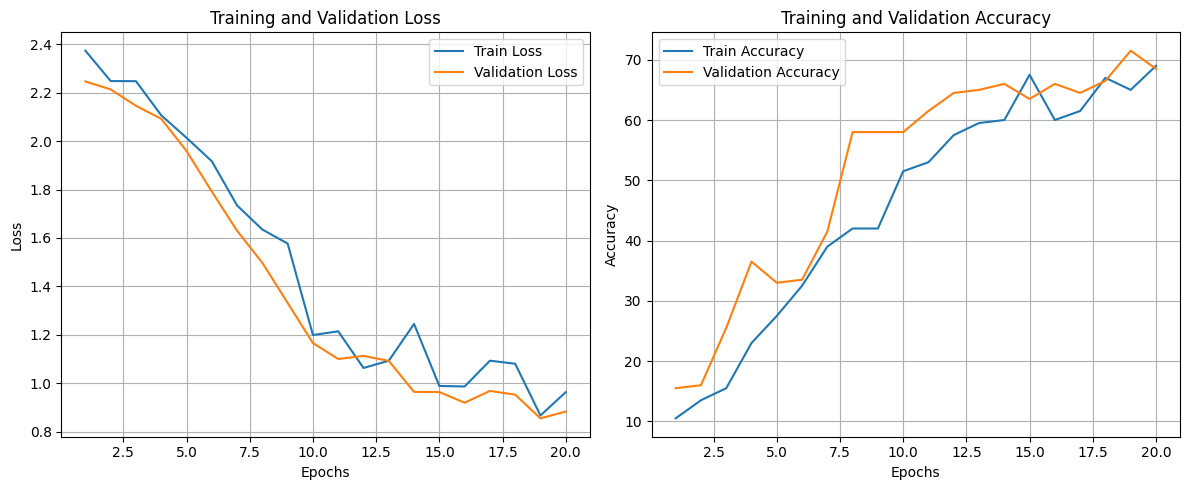

Acurácia final no conjunto de validação:
Acurácia da rede na base de teste: 68.50%

Treinando modelo: conv1_out=6, conv2_out=16


100%|██████████| 4/4 [00:00<00:00, 24.82it/s]


Epoch 1, Train Loss: 2.411, Train Accuracy: 5.00%
Epoch 1, Val Loss: 2.199, Val Accuracy: 10.50%


100%|██████████| 4/4 [00:00<00:00, 41.45it/s]


Epoch 2, Train Loss: 2.253, Train Accuracy: 15.00%
Epoch 2, Val Loss: 2.122, Val Accuracy: 16.50%


100%|██████████| 4/4 [00:00<00:00, 54.77it/s]


Epoch 3, Train Loss: 2.170, Train Accuracy: 16.00%
Epoch 3, Val Loss: 2.089, Val Accuracy: 18.00%


100%|██████████| 4/4 [00:00<00:00, 44.59it/s]


Epoch 4, Train Loss: 2.073, Train Accuracy: 28.50%
Epoch 4, Val Loss: 2.007, Val Accuracy: 34.00%


100%|██████████| 4/4 [00:00<00:00, 54.32it/s]


Epoch 5, Train Loss: 1.941, Train Accuracy: 30.50%
Epoch 5, Val Loss: 1.822, Val Accuracy: 36.50%


100%|██████████| 4/4 [00:00<00:00, 39.01it/s]


Epoch 6, Train Loss: 1.814, Train Accuracy: 39.50%
Epoch 6, Val Loss: 1.632, Val Accuracy: 46.00%


100%|██████████| 4/4 [00:00<00:00, 39.87it/s]


Epoch 7, Train Loss: 1.470, Train Accuracy: 41.50%
Epoch 7, Val Loss: 1.497, Val Accuracy: 50.00%


100%|██████████| 4/4 [00:00<00:00, 39.48it/s]


Epoch 8, Train Loss: 1.615, Train Accuracy: 38.00%
Epoch 8, Val Loss: 1.426, Val Accuracy: 53.50%


100%|██████████| 4/4 [00:00<00:00, 31.08it/s]

Epoch 9, Train Loss: 1.469, Train Accuracy: 43.00%


Epoch 9, Val Loss: 1.321, Val Accuracy: 53.00%


100%|██████████| 4/4 [00:00<00:00, 42.53it/s]


Epoch 10, Train Loss: 1.281, Train Accuracy: 48.50%
Epoch 10, Val Loss: 1.278, Val Accuracy: 59.50%


100%|██████████| 4/4 [00:00<00:00, 20.10it/s]


Epoch 11, Train Loss: 1.237, Train Accuracy: 52.00%
Epoch 11, Val Loss: 1.135, Val Accuracy: 57.50%


100%|██████████| 4/4 [00:00<00:00, 24.71it/s]


Epoch 12, Train Loss: 1.127, Train Accuracy: 54.50%
Epoch 12, Val Loss: 1.029, Val Accuracy: 62.00%


100%|██████████| 4/4 [00:00<00:00, 48.44it/s]


Epoch 13, Train Loss: 1.209, Train Accuracy: 60.50%
Epoch 13, Val Loss: 0.971, Val Accuracy: 65.50%


100%|██████████| 4/4 [00:00<00:00, 28.74it/s]

Epoch 14, Train Loss: 1.022, Train Accuracy: 60.50%


Epoch 14, Val Loss: 0.914, Val Accuracy: 66.00%


100%|██████████| 4/4 [00:00<00:00, 44.20it/s]


Epoch 15, Train Loss: 0.979, Train Accuracy: 64.50%
Epoch 15, Val Loss: 0.970, Val Accuracy: 64.00%


100%|██████████| 4/4 [00:00<00:00, 30.80it/s]


Epoch 16, Train Loss: 1.040, Train Accuracy: 58.50%
Epoch 16, Val Loss: 0.964, Val Accuracy: 62.00%


100%|██████████| 4/4 [00:00<00:00, 54.29it/s]


Epoch 17, Train Loss: 1.020, Train Accuracy: 63.50%
Epoch 17, Val Loss: 0.905, Val Accuracy: 66.00%


100%|██████████| 4/4 [00:00<00:00, 20.20it/s]


Epoch 18, Train Loss: 0.885, Train Accuracy: 65.50%
Epoch 18, Val Loss: 0.837, Val Accuracy: 68.50%


100%|██████████| 4/4 [00:00<00:00, 48.74it/s]


Epoch 19, Train Loss: 1.013, Train Accuracy: 67.00%
Epoch 19, Val Loss: 0.820, Val Accuracy: 68.00%


100%|██████████| 4/4 [00:00<00:00, 44.07it/s]


Epoch 20, Train Loss: 0.920, Train Accuracy: 65.50%
Epoch 20, Val Loss: 0.887, Val Accuracy: 64.00%
Treinamento concluído


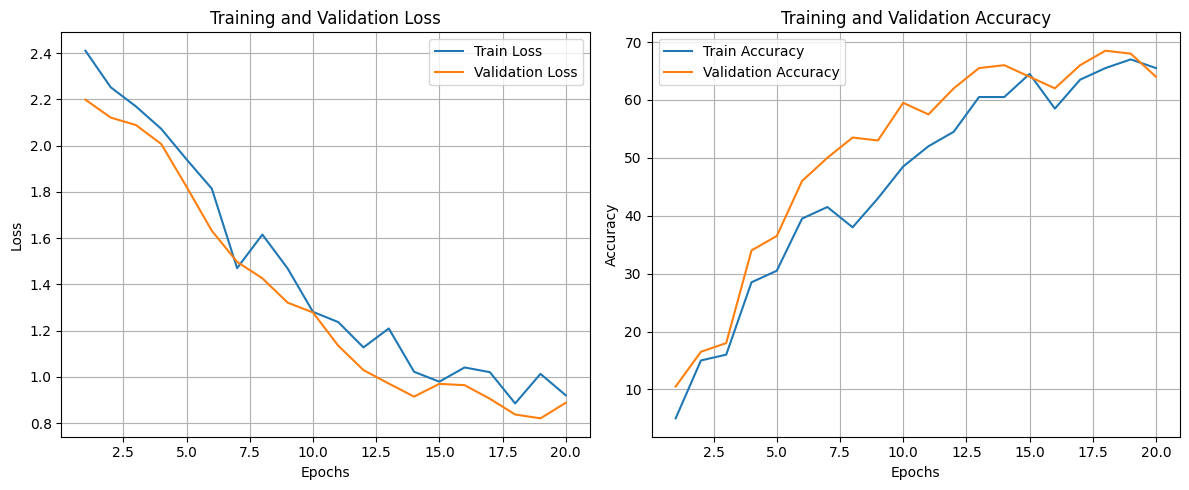

Acurácia final no conjunto de validação:
Acurácia da rede na base de teste: 64.00%

Treinando modelo: conv1_out=8, conv2_out=12


100%|██████████| 4/4 [00:00<00:00, 29.46it/s]


Epoch 1, Train Loss: 2.304, Train Accuracy: 12.50%
Epoch 1, Val Loss: 2.196, Val Accuracy: 12.00%


100%|██████████| 4/4 [00:00<00:00, 31.72it/s]


Epoch 2, Train Loss: 2.189, Train Accuracy: 20.50%
Epoch 2, Val Loss: 2.132, Val Accuracy: 29.00%


100%|██████████| 4/4 [00:00<00:00, 23.12it/s]


Epoch 3, Train Loss: 2.170, Train Accuracy: 28.00%
Epoch 3, Val Loss: 1.994, Val Accuracy: 37.00%


100%|██████████| 4/4 [00:00<00:00, 36.45it/s]


Epoch 4, Train Loss: 1.928, Train Accuracy: 32.00%
Epoch 4, Val Loss: 1.831, Val Accuracy: 42.50%


100%|██████████| 4/4 [00:00<00:00, 46.58it/s]


Epoch 5, Train Loss: 1.847, Train Accuracy: 30.50%
Epoch 5, Val Loss: 1.715, Val Accuracy: 44.00%


100%|██████████| 4/4 [00:00<00:00, 37.89it/s]


Epoch 6, Train Loss: 1.832, Train Accuracy: 34.00%
Epoch 6, Val Loss: 1.667, Val Accuracy: 48.00%


100%|██████████| 4/4 [00:00<00:00, 41.30it/s]


Epoch 7, Train Loss: 1.621, Train Accuracy: 43.00%
Epoch 7, Val Loss: 1.497, Val Accuracy: 52.50%


100%|██████████| 4/4 [00:00<00:00, 45.67it/s]


Epoch 8, Train Loss: 1.649, Train Accuracy: 43.50%
Epoch 8, Val Loss: 1.386, Val Accuracy: 59.00%


100%|██████████| 4/4 [00:00<00:00, 27.20it/s]

Epoch 9, Train Loss: 1.418, Train Accuracy: 50.00%


Epoch 9, Val Loss: 1.307, Val Accuracy: 59.00%


100%|██████████| 4/4 [00:00<00:00, 43.16it/s]


Epoch 10, Train Loss: 1.401, Train Accuracy: 52.50%
Epoch 10, Val Loss: 1.191, Val Accuracy: 63.00%


100%|██████████| 4/4 [00:00<00:00, 48.73it/s]


Epoch 11, Train Loss: 1.197, Train Accuracy: 53.00%
Epoch 11, Val Loss: 1.098, Val Accuracy: 66.50%


100%|██████████| 4/4 [00:00<00:00, 53.12it/s]


Epoch 12, Train Loss: 1.125, Train Accuracy: 61.50%
Epoch 12, Val Loss: 1.116, Val Accuracy: 63.50%


100%|██████████| 4/4 [00:00<00:00, 39.29it/s]


Epoch 13, Train Loss: 1.161, Train Accuracy: 57.50%
Epoch 13, Val Loss: 1.047, Val Accuracy: 63.50%


100%|██████████| 4/4 [00:00<00:00, 38.63it/s]


Epoch 14, Train Loss: 1.003, Train Accuracy: 65.00%
Epoch 14, Val Loss: 0.889, Val Accuracy: 72.50%


100%|██████████| 4/4 [00:00<00:00, 31.65it/s]

Epoch 15, Train Loss: 1.026, Train Accuracy: 65.00%


Epoch 15, Val Loss: 0.905, Val Accuracy: 70.50%


100%|██████████| 4/4 [00:00<00:00, 32.36it/s]


Epoch 16, Train Loss: 1.007, Train Accuracy: 65.00%
Epoch 16, Val Loss: 0.900, Val Accuracy: 70.00%


100%|██████████| 4/4 [00:00<00:00, 27.29it/s]


Epoch 17, Train Loss: 1.241, Train Accuracy: 62.00%
Epoch 17, Val Loss: 1.029, Val Accuracy: 66.00%


100%|██████████| 4/4 [00:00<00:00, 25.63it/s]


Epoch 18, Train Loss: 0.901, Train Accuracy: 66.00%
Epoch 18, Val Loss: 0.943, Val Accuracy: 73.00%


100%|██████████| 4/4 [00:00<00:00, 28.65it/s]


Epoch 19, Train Loss: 0.937, Train Accuracy: 67.50%
Epoch 19, Val Loss: 0.869, Val Accuracy: 69.00%


100%|██████████| 4/4 [00:00<00:00, 32.69it/s]


Epoch 20, Train Loss: 1.032, Train Accuracy: 64.00%
Epoch 20, Val Loss: 0.832, Val Accuracy: 70.00%
Treinamento concluído


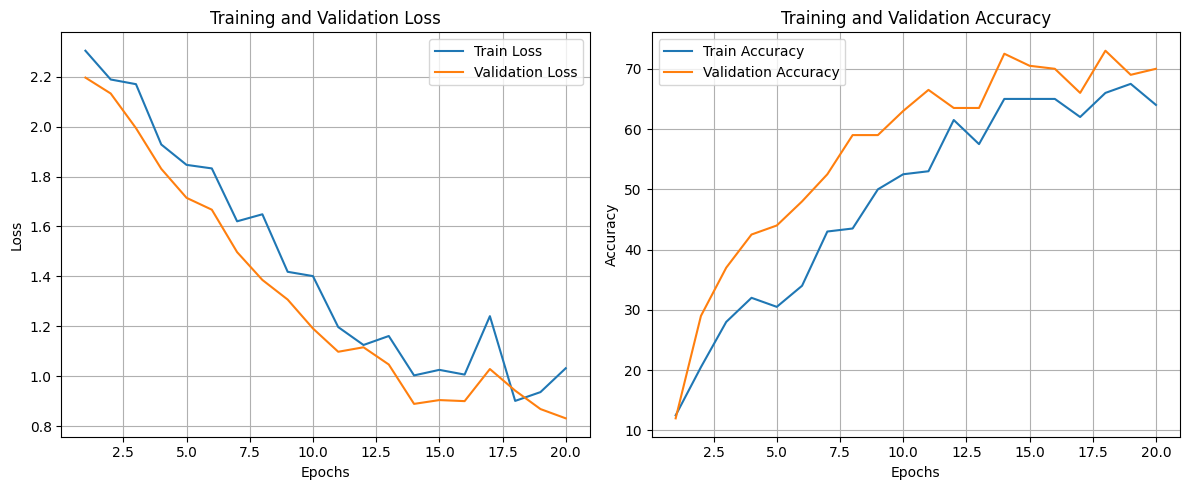

Acurácia final no conjunto de validação:
Acurácia da rede na base de teste: 70.00%

Treinando modelo: conv1_out=8, conv2_out=16


100%|██████████| 4/4 [00:00<00:00, 33.42it/s]


Epoch 1, Train Loss: 2.420, Train Accuracy: 10.00%
Epoch 1, Val Loss: 2.290, Val Accuracy: 8.50%


100%|██████████| 4/4 [00:00<00:00, 16.31it/s]


Epoch 2, Train Loss: 2.258, Train Accuracy: 17.00%
Epoch 2, Val Loss: 2.198, Val Accuracy: 13.00%


100%|██████████| 4/4 [00:00<00:00, 36.03it/s]


Epoch 3, Train Loss: 2.254, Train Accuracy: 18.00%
Epoch 3, Val Loss: 2.141, Val Accuracy: 22.00%


100%|██████████| 4/4 [00:00<00:00, 18.25it/s]


Epoch 4, Train Loss: 2.137, Train Accuracy: 30.00%
Epoch 4, Val Loss: 2.063, Val Accuracy: 37.50%


100%|██████████| 4/4 [00:00<00:00, 27.31it/s]


Epoch 5, Train Loss: 2.018, Train Accuracy: 31.00%
Epoch 5, Val Loss: 1.960, Val Accuracy: 40.50%


100%|██████████| 4/4 [00:00<00:00, 41.48it/s]


Epoch 6, Train Loss: 1.879, Train Accuracy: 33.00%
Epoch 6, Val Loss: 1.824, Val Accuracy: 46.00%


100%|██████████| 4/4 [00:00<00:00, 28.12it/s]

Epoch 7, Train Loss: 1.755, Train Accuracy: 38.00%


Epoch 7, Val Loss: 1.697, Val Accuracy: 46.00%


100%|██████████| 4/4 [00:00<00:00, 34.77it/s]


Epoch 8, Train Loss: 1.591, Train Accuracy: 42.00%
Epoch 8, Val Loss: 1.505, Val Accuracy: 51.00%


100%|██████████| 4/4 [00:00<00:00, 29.05it/s]

Epoch 9, Train Loss: 1.696, Train Accuracy: 48.50%


Epoch 9, Val Loss: 1.393, Val Accuracy: 53.00%


100%|██████████| 4/4 [00:00<00:00, 32.94it/s]

Epoch 10, Train Loss: 1.407, Train Accuracy: 53.50%


Epoch 10, Val Loss: 1.248, Val Accuracy: 59.00%


100%|██████████| 4/4 [00:00<00:00, 30.88it/s]

Epoch 11, Train Loss: 1.277, Train Accuracy: 53.00%


Epoch 11, Val Loss: 1.149, Val Accuracy: 69.50%


100%|██████████| 4/4 [00:00<00:00, 32.16it/s]

Epoch 12, Train Loss: 1.275, Train Accuracy: 60.00%


Epoch 12, Val Loss: 1.076, Val Accuracy: 68.50%


100%|██████████| 4/4 [00:00<00:00, 14.07it/s]


Epoch 13, Train Loss: 0.995, Train Accuracy: 65.50%
Epoch 13, Val Loss: 1.071, Val Accuracy: 58.00%


100%|██████████| 4/4 [00:00<00:00, 23.98it/s]


Epoch 14, Train Loss: 1.135, Train Accuracy: 64.50%
Epoch 14, Val Loss: 1.025, Val Accuracy: 61.50%


100%|██████████| 4/4 [00:00<00:00, 29.49it/s]


Epoch 15, Train Loss: 1.035, Train Accuracy: 67.50%
Epoch 15, Val Loss: 0.980, Val Accuracy: 63.50%


100%|██████████| 4/4 [00:00<00:00, 35.09it/s]


Epoch 16, Train Loss: 0.929, Train Accuracy: 63.50%
Epoch 16, Val Loss: 0.925, Val Accuracy: 70.50%


100%|██████████| 4/4 [00:00<00:00, 20.52it/s]

Epoch 17, Train Loss: 0.830, Train Accuracy: 68.50%


Epoch 17, Val Loss: 0.873, Val Accuracy: 69.50%


100%|██████████| 4/4 [00:00<00:00, 37.14it/s]


Epoch 18, Train Loss: 0.864, Train Accuracy: 68.00%
Epoch 18, Val Loss: 0.913, Val Accuracy: 71.00%


100%|██████████| 4/4 [00:00<00:00, 20.48it/s]


Epoch 19, Train Loss: 0.761, Train Accuracy: 70.50%
Epoch 19, Val Loss: 0.959, Val Accuracy: 67.00%


100%|██████████| 4/4 [00:00<00:00, 38.05it/s]


Epoch 20, Train Loss: 0.683, Train Accuracy: 72.00%
Epoch 20, Val Loss: 0.881, Val Accuracy: 67.50%
Treinamento concluído


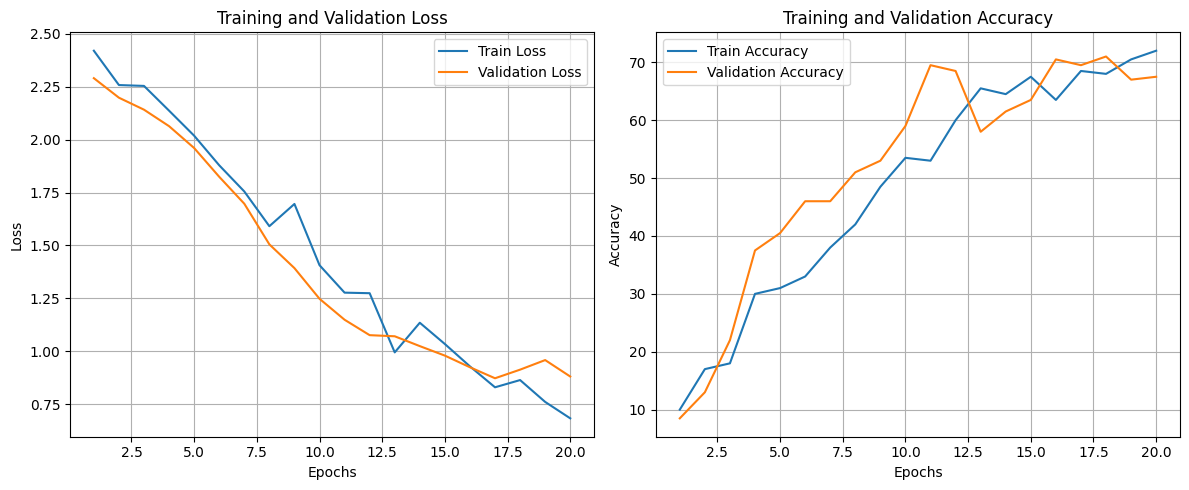

Acurácia final no conjunto de validação:
Acurácia da rede na base de teste: 67.50%

Resumo das melhores acurácias de validação para cada configuração:
conv1_out=6, conv2_out=12: 68.50%
conv1_out=6, conv2_out=16: 64.00%
conv1_out=8, conv2_out=12: 70.00%
conv1_out=8, conv2_out=16: 67.50%


In [10]:
class CNNFlexible(nn.Module):
    def __init__(self, conv1_out=6, conv2_out=12, dropout=0.2, initialize_weights=True):
        super().__init__()
        self.conv1 = nn.Conv2d(1, conv1_out, 5)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, 5)
        self.fc1 = nn.Linear(conv2_out * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.fc1.in_features)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

results = {}
for conv1_out in [6, 8]:
    for conv2_out in [12, 16]:
        print(f"\nTreinando modelo: conv1_out={conv1_out}, conv2_out={conv2_out}")
        model = CNNFlexible(conv1_out=conv1_out, conv2_out=conv2_out, dropout=0.5, initialize_weights=True)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        history = train_model(
            model=model,
            trainloader=train_loader,
            valloader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            num_epochs=20
        )
        plot_training_history(history)
        print("Acurácia final no conjunto de validação:")
        test_model(model, val_loader)
        results[(conv1_out, conv2_out)] = history['val_accuracies'][-1]

print("\nResumo das melhores acurácias de validação para cada configuração:")
for k, v in results.items():
    print(f"conv1_out={k[0]}, conv2_out={k[1]}: {v:.2f}%")

### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?


Treinando modelo com fc1_out=25


100%|██████████| 4/4 [00:00<00:00, 36.13it/s]


Epoch 1, Train Loss: 2.396, Train Accuracy: 11.00%
Epoch 1, Val Loss: 2.272, Val Accuracy: 13.50%


100%|██████████| 4/4 [00:00<00:00, 21.30it/s]


Epoch 2, Train Loss: 2.276, Train Accuracy: 9.50%
Epoch 2, Val Loss: 2.237, Val Accuracy: 19.50%


100%|██████████| 4/4 [00:00<00:00, 42.79it/s]


Epoch 3, Train Loss: 2.233, Train Accuracy: 16.50%
Epoch 3, Val Loss: 2.202, Val Accuracy: 27.50%


100%|██████████| 4/4 [00:00<00:00, 39.65it/s]


Epoch 4, Train Loss: 2.185, Train Accuracy: 21.50%
Epoch 4, Val Loss: 2.127, Val Accuracy: 38.00%


100%|██████████| 4/4 [00:00<00:00, 48.23it/s]


Epoch 5, Train Loss: 2.114, Train Accuracy: 26.50%
Epoch 5, Val Loss: 2.020, Val Accuracy: 35.50%


100%|██████████| 4/4 [00:00<00:00, 50.44it/s]


Epoch 6, Train Loss: 2.008, Train Accuracy: 26.50%
Epoch 6, Val Loss: 1.855, Val Accuracy: 46.50%


100%|██████████| 4/4 [00:00<00:00, 37.43it/s]


Epoch 7, Train Loss: 1.970, Train Accuracy: 25.50%
Epoch 7, Val Loss: 1.712, Val Accuracy: 44.50%


100%|██████████| 4/4 [00:00<00:00, 39.50it/s]


Epoch 8, Train Loss: 1.841, Train Accuracy: 37.00%
Epoch 8, Val Loss: 1.619, Val Accuracy: 48.50%


100%|██████████| 4/4 [00:00<00:00, 29.81it/s]

Epoch 9, Train Loss: 1.742, Train Accuracy: 36.00%


Epoch 9, Val Loss: 1.532, Val Accuracy: 39.50%


100%|██████████| 4/4 [00:00<00:00, 22.22it/s]

Epoch 10, Train Loss: 1.720, Train Accuracy: 39.50%


Epoch 10, Val Loss: 1.467, Val Accuracy: 48.50%


100%|██████████| 4/4 [00:00<00:00, 32.50it/s]


Epoch 11, Train Loss: 1.607, Train Accuracy: 38.00%
Epoch 11, Val Loss: 1.472, Val Accuracy: 50.50%


100%|██████████| 4/4 [00:00<00:00, 32.75it/s]


Epoch 12, Train Loss: 1.423, Train Accuracy: 43.50%
Epoch 12, Val Loss: 1.375, Val Accuracy: 58.00%


100%|██████████| 4/4 [00:00<00:00, 28.13it/s]

Epoch 13, Train Loss: 1.613, Train Accuracy: 45.50%


Epoch 13, Val Loss: 1.351, Val Accuracy: 55.00%


100%|██████████| 4/4 [00:00<00:00, 34.98it/s]


Epoch 14, Train Loss: 1.308, Train Accuracy: 46.50%
Epoch 14, Val Loss: 1.424, Val Accuracy: 55.00%


100%|██████████| 4/4 [00:00<00:00, 34.18it/s]


Epoch 15, Train Loss: 1.476, Train Accuracy: 49.50%
Epoch 15, Val Loss: 1.372, Val Accuracy: 57.00%


100%|██████████| 4/4 [00:00<00:00, 29.83it/s]


Epoch 16, Train Loss: 1.295, Train Accuracy: 56.50%
Epoch 16, Val Loss: 1.300, Val Accuracy: 66.00%


100%|██████████| 4/4 [00:00<00:00, 27.78it/s]


Epoch 17, Train Loss: 1.346, Train Accuracy: 46.50%
Epoch 17, Val Loss: 1.244, Val Accuracy: 65.00%


100%|██████████| 4/4 [00:00<00:00, 37.21it/s]


Epoch 18, Train Loss: 1.239, Train Accuracy: 54.50%
Epoch 18, Val Loss: 1.177, Val Accuracy: 64.00%


100%|██████████| 4/4 [00:00<00:00, 49.71it/s]


Epoch 19, Train Loss: 1.042, Train Accuracy: 61.00%
Epoch 19, Val Loss: 1.124, Val Accuracy: 64.50%


100%|██████████| 4/4 [00:00<00:00, 47.69it/s]


Epoch 20, Train Loss: 1.211, Train Accuracy: 53.50%
Epoch 20, Val Loss: 1.075, Val Accuracy: 62.50%
Treinamento concluído


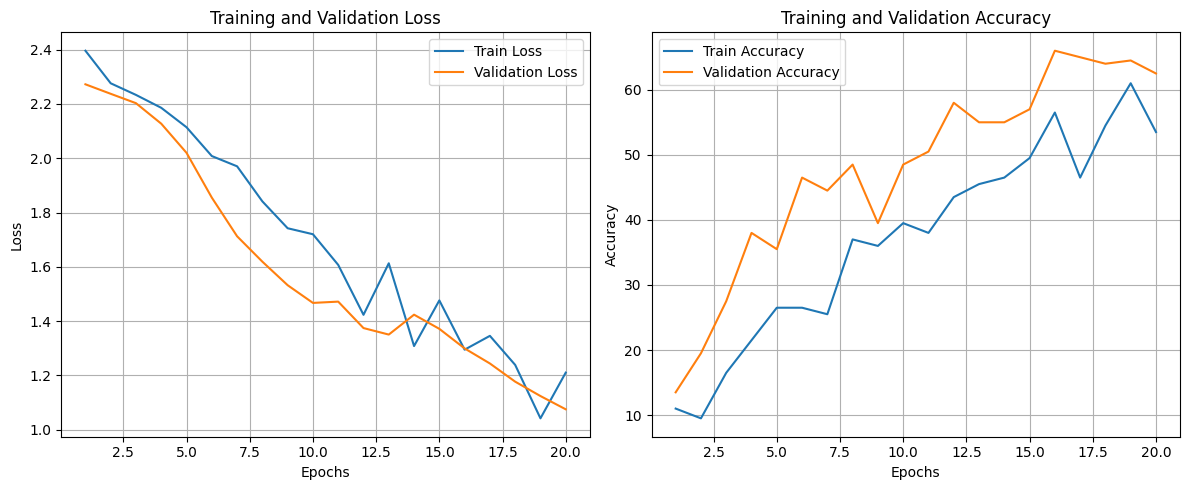

Acurácia final no conjunto de validação:
Acurácia da rede na base de teste: 62.50%

Treinando modelo com fc1_out=13


100%|██████████| 4/4 [00:00<00:00, 30.23it/s]


Epoch 1, Train Loss: 2.471, Train Accuracy: 12.50%
Epoch 1, Val Loss: 2.294, Val Accuracy: 9.00%


100%|██████████| 4/4 [00:00<00:00, 54.91it/s]


Epoch 2, Train Loss: 2.288, Train Accuracy: 7.50%
Epoch 2, Val Loss: 2.281, Val Accuracy: 4.00%


100%|██████████| 4/4 [00:00<00:00, 44.90it/s]


Epoch 3, Train Loss: 2.269, Train Accuracy: 7.50%
Epoch 3, Val Loss: 2.271, Val Accuracy: 12.50%


100%|██████████| 4/4 [00:00<00:00, 48.80it/s]


Epoch 4, Train Loss: 2.270, Train Accuracy: 8.50%
Epoch 4, Val Loss: 2.253, Val Accuracy: 17.50%


100%|██████████| 4/4 [00:00<00:00, 28.05it/s]

Epoch 5, Train Loss: 2.237, Train Accuracy: 15.00%


Epoch 5, Val Loss: 2.226, Val Accuracy: 18.50%


100%|██████████| 4/4 [00:00<00:00, 38.01it/s]


Epoch 6, Train Loss: 2.166, Train Accuracy: 16.00%
Epoch 6, Val Loss: 2.187, Val Accuracy: 18.50%


100%|██████████| 4/4 [00:00<00:00, 42.73it/s]


Epoch 7, Train Loss: 2.188, Train Accuracy: 15.00%
Epoch 7, Val Loss: 2.127, Val Accuracy: 20.50%


100%|██████████| 4/4 [00:00<00:00, 52.99it/s]


Epoch 8, Train Loss: 2.113, Train Accuracy: 17.50%
Epoch 8, Val Loss: 2.047, Val Accuracy: 28.50%


100%|██████████| 4/4 [00:00<00:00, 44.34it/s]


Epoch 9, Train Loss: 2.070, Train Accuracy: 26.00%
Epoch 9, Val Loss: 1.959, Val Accuracy: 37.50%


100%|██████████| 4/4 [00:00<00:00, 24.70it/s]


Epoch 10, Train Loss: 1.978, Train Accuracy: 24.50%
Epoch 10, Val Loss: 1.860, Val Accuracy: 38.50%


100%|██████████| 4/4 [00:00<00:00, 44.94it/s]


Epoch 11, Train Loss: 1.964, Train Accuracy: 28.50%
Epoch 11, Val Loss: 1.744, Val Accuracy: 44.50%


100%|██████████| 4/4 [00:00<00:00, 23.63it/s]

Epoch 12, Train Loss: 1.832, Train Accuracy: 25.00%


Epoch 12, Val Loss: 1.675, Val Accuracy: 43.00%


100%|██████████| 4/4 [00:00<00:00, 48.85it/s]


Epoch 13, Train Loss: 1.857, Train Accuracy: 27.50%
Epoch 13, Val Loss: 1.597, Val Accuracy: 44.00%


100%|██████████| 4/4 [00:00<00:00, 20.83it/s]

Epoch 14, Train Loss: 1.904, Train Accuracy: 25.50%


Epoch 14, Val Loss: 1.551, Val Accuracy: 46.50%


100%|██████████| 4/4 [00:00<00:00, 36.67it/s]


Epoch 15, Train Loss: 1.834, Train Accuracy: 28.00%
Epoch 15, Val Loss: 1.516, Val Accuracy: 51.50%


100%|██████████| 4/4 [00:00<00:00, 42.23it/s]


Epoch 16, Train Loss: 1.664, Train Accuracy: 36.50%
Epoch 16, Val Loss: 1.469, Val Accuracy: 52.50%


100%|██████████| 4/4 [00:00<00:00, 46.08it/s]


Epoch 17, Train Loss: 1.832, Train Accuracy: 24.50%
Epoch 17, Val Loss: 1.386, Val Accuracy: 47.00%


100%|██████████| 4/4 [00:00<00:00, 52.47it/s]


Epoch 18, Train Loss: 1.773, Train Accuracy: 33.50%
Epoch 18, Val Loss: 1.509, Val Accuracy: 40.00%


100%|██████████| 4/4 [00:00<00:00, 44.78it/s]


Epoch 19, Train Loss: 1.828, Train Accuracy: 27.50%
Epoch 19, Val Loss: 1.503, Val Accuracy: 44.50%


100%|██████████| 4/4 [00:00<00:00, 45.57it/s]


Epoch 20, Train Loss: 1.761, Train Accuracy: 32.50%
Epoch 20, Val Loss: 1.536, Val Accuracy: 45.00%
Treinamento concluído


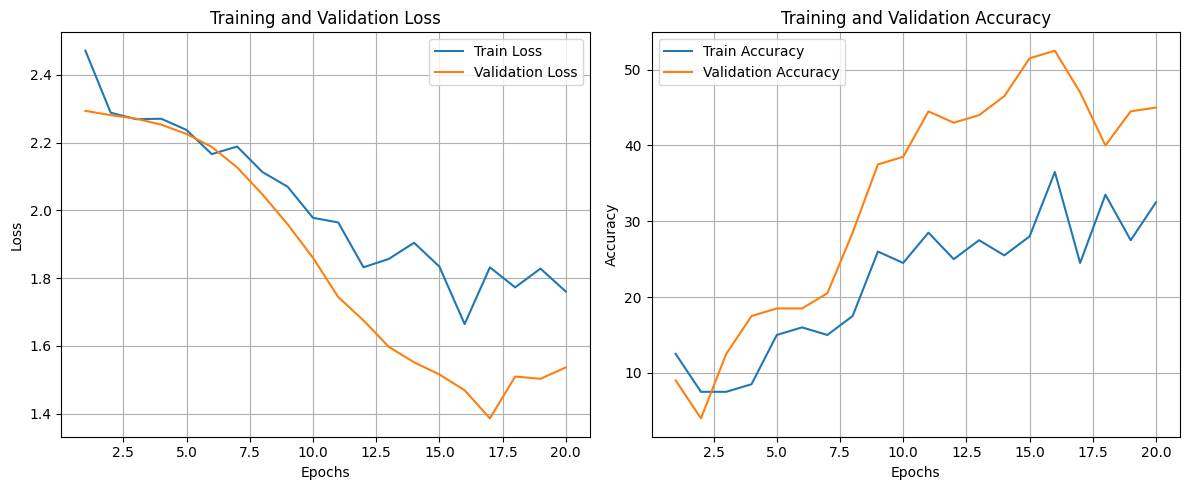

Acurácia final no conjunto de validação:
Acurácia da rede na base de teste: 45.00%

Treinando modelo com fc1_out=65


100%|██████████| 4/4 [00:00<00:00, 50.39it/s]

Epoch 1, Train Loss: 2.348, Train Accuracy: 9.50%


Epoch 1, Val Loss: 2.250, Val Accuracy: 15.00%


100%|██████████| 4/4 [00:00<00:00, 35.18it/s]


Epoch 2, Train Loss: 2.287, Train Accuracy: 17.00%
Epoch 2, Val Loss: 2.217, Val Accuracy: 21.50%


100%|██████████| 4/4 [00:00<00:00, 37.68it/s]


Epoch 3, Train Loss: 2.229, Train Accuracy: 24.50%
Epoch 3, Val Loss: 2.181, Val Accuracy: 27.50%


100%|██████████| 4/4 [00:00<00:00, 14.99it/s]


Epoch 4, Train Loss: 2.135, Train Accuracy: 24.50%
Epoch 4, Val Loss: 2.063, Val Accuracy: 39.50%


100%|██████████| 4/4 [00:00<00:00, 34.01it/s]


Epoch 5, Train Loss: 1.928, Train Accuracy: 33.50%
Epoch 5, Val Loss: 1.847, Val Accuracy: 43.50%


100%|██████████| 4/4 [00:00<00:00, 34.86it/s]


Epoch 6, Train Loss: 1.789, Train Accuracy: 34.50%
Epoch 6, Val Loss: 1.654, Val Accuracy: 48.00%


100%|██████████| 4/4 [00:00<00:00, 19.99it/s]


Epoch 7, Train Loss: 1.687, Train Accuracy: 39.00%
Epoch 7, Val Loss: 1.516, Val Accuracy: 58.00%


100%|██████████| 4/4 [00:00<00:00, 40.19it/s]


Epoch 8, Train Loss: 1.482, Train Accuracy: 48.00%
Epoch 8, Val Loss: 1.349, Val Accuracy: 59.50%


100%|██████████| 4/4 [00:00<00:00, 31.41it/s]

Epoch 9, Train Loss: 1.358, Train Accuracy: 48.00%


Epoch 9, Val Loss: 1.151, Val Accuracy: 61.00%


100%|██████████| 4/4 [00:00<00:00, 17.12it/s]


Epoch 10, Train Loss: 1.255, Train Accuracy: 57.50%
Epoch 10, Val Loss: 1.094, Val Accuracy: 67.00%


100%|██████████| 4/4 [00:00<00:00, 28.73it/s]


Epoch 11, Train Loss: 1.232, Train Accuracy: 57.00%
Epoch 11, Val Loss: 1.125, Val Accuracy: 65.50%


100%|██████████| 4/4 [00:00<00:00, 43.84it/s]


Epoch 12, Train Loss: 1.217, Train Accuracy: 57.50%
Epoch 12, Val Loss: 1.112, Val Accuracy: 67.00%


100%|██████████| 4/4 [00:00<00:00, 42.86it/s]


Epoch 13, Train Loss: 1.068, Train Accuracy: 60.50%
Epoch 13, Val Loss: 1.040, Val Accuracy: 67.00%


100%|██████████| 4/4 [00:00<00:00, 38.65it/s]


Epoch 14, Train Loss: 0.951, Train Accuracy: 64.50%
Epoch 14, Val Loss: 1.000, Val Accuracy: 67.00%


100%|██████████| 4/4 [00:00<00:00, 39.61it/s]


Epoch 15, Train Loss: 1.026, Train Accuracy: 63.50%
Epoch 15, Val Loss: 0.973, Val Accuracy: 68.00%


100%|██████████| 4/4 [00:00<00:00, 41.25it/s]


Epoch 16, Train Loss: 0.981, Train Accuracy: 61.50%
Epoch 16, Val Loss: 0.960, Val Accuracy: 69.50%


100%|██████████| 4/4 [00:00<00:00, 28.20it/s]

Epoch 17, Train Loss: 0.874, Train Accuracy: 70.50%


Epoch 17, Val Loss: 0.892, Val Accuracy: 69.50%


100%|██████████| 4/4 [00:00<00:00, 34.54it/s]

Epoch 18, Train Loss: 0.882, Train Accuracy: 72.00%


Epoch 18, Val Loss: 0.908, Val Accuracy: 65.00%


100%|██████████| 4/4 [00:00<00:00, 16.84it/s]


Epoch 19, Train Loss: 0.768, Train Accuracy: 68.50%
Epoch 19, Val Loss: 0.854, Val Accuracy: 67.00%


100%|██████████| 4/4 [00:00<00:00, 34.24it/s]


Epoch 20, Train Loss: 0.626, Train Accuracy: 75.00%
Epoch 20, Val Loss: 0.832, Val Accuracy: 68.50%
Treinamento concluído


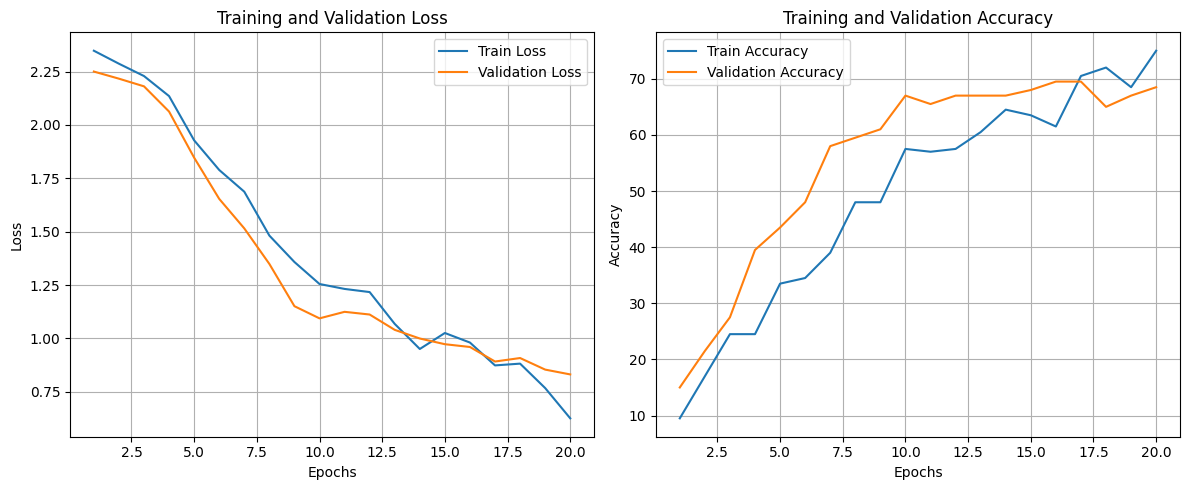

Acurácia final no conjunto de validação:
Acurácia da rede na base de teste: 68.50%

Treinando modelo com fc1_out=12


100%|██████████| 4/4 [00:00<00:00, 29.95it/s]


Epoch 1, Train Loss: 2.474, Train Accuracy: 9.00%
Epoch 1, Val Loss: 2.316, Val Accuracy: 7.00%


100%|██████████| 4/4 [00:00<00:00, 33.30it/s]


Epoch 2, Train Loss: 2.313, Train Accuracy: 14.00%
Epoch 2, Val Loss: 2.303, Val Accuracy: 7.00%


100%|██████████| 4/4 [00:00<00:00, 32.88it/s]


Epoch 3, Train Loss: 2.308, Train Accuracy: 7.00%
Epoch 3, Val Loss: 2.299, Val Accuracy: 10.50%


100%|██████████| 4/4 [00:00<00:00, 32.94it/s]


Epoch 4, Train Loss: 2.308, Train Accuracy: 13.50%
Epoch 4, Val Loss: 2.296, Val Accuracy: 12.00%


100%|██████████| 4/4 [00:00<00:00, 20.04it/s]


Epoch 5, Train Loss: 2.296, Train Accuracy: 13.00%
Epoch 5, Val Loss: 2.297, Val Accuracy: 16.50%


100%|██████████| 4/4 [00:00<00:00, 40.17it/s]


Epoch 6, Train Loss: 2.290, Train Accuracy: 18.50%
Epoch 6, Val Loss: 2.295, Val Accuracy: 16.50%


100%|██████████| 4/4 [00:00<00:00, 32.66it/s]

Epoch 7, Train Loss: 2.284, Train Accuracy: 16.00%


Epoch 7, Val Loss: 2.293, Val Accuracy: 15.50%


100%|██████████| 4/4 [00:00<00:00, 15.89it/s]


Epoch 8, Train Loss: 2.278, Train Accuracy: 17.00%
Epoch 8, Val Loss: 2.285, Val Accuracy: 21.00%


100%|██████████| 4/4 [00:00<00:00, 29.27it/s]


Epoch 9, Train Loss: 2.271, Train Accuracy: 20.50%
Epoch 9, Val Loss: 2.272, Val Accuracy: 13.50%


100%|██████████| 4/4 [00:00<00:00, 38.20it/s]


Epoch 10, Train Loss: 2.222, Train Accuracy: 15.50%
Epoch 10, Val Loss: 2.258, Val Accuracy: 13.50%


100%|██████████| 4/4 [00:00<00:00, 44.12it/s]


Epoch 11, Train Loss: 2.217, Train Accuracy: 16.50%
Epoch 11, Val Loss: 2.249, Val Accuracy: 15.00%


100%|██████████| 4/4 [00:00<00:00, 30.93it/s]

Epoch 12, Train Loss: 2.252, Train Accuracy: 14.50%


Epoch 12, Val Loss: 2.213, Val Accuracy: 19.00%


100%|██████████| 4/4 [00:00<00:00, 26.25it/s]

Epoch 13, Train Loss: 2.234, Train Accuracy: 14.50%


Epoch 13, Val Loss: 2.213, Val Accuracy: 22.50%


100%|██████████| 4/4 [00:00<00:00, 15.42it/s]


Epoch 14, Train Loss: 2.233, Train Accuracy: 18.50%
Epoch 14, Val Loss: 2.227, Val Accuracy: 22.00%


100%|██████████| 4/4 [00:00<00:00, 31.46it/s]


Epoch 15, Train Loss: 2.199, Train Accuracy: 19.00%
Epoch 15, Val Loss: 2.213, Val Accuracy: 26.00%


100%|██████████| 4/4 [00:00<00:00, 29.10it/s]


Epoch 16, Train Loss: 2.096, Train Accuracy: 19.50%
Epoch 16, Val Loss: 2.129, Val Accuracy: 27.00%


100%|██████████| 4/4 [00:00<00:00, 17.97it/s]


Epoch 17, Train Loss: 1.984, Train Accuracy: 24.50%
Epoch 17, Val Loss: 2.042, Val Accuracy: 31.00%


100%|██████████| 4/4 [00:00<00:00, 38.95it/s]


Epoch 18, Train Loss: 2.131, Train Accuracy: 20.50%
Epoch 18, Val Loss: 1.983, Val Accuracy: 32.00%


100%|██████████| 4/4 [00:00<00:00, 33.90it/s]


Epoch 19, Train Loss: 2.067, Train Accuracy: 19.00%
Epoch 19, Val Loss: 1.944, Val Accuracy: 31.00%


100%|██████████| 4/4 [00:00<00:00, 17.69it/s]


Epoch 20, Train Loss: 1.954, Train Accuracy: 24.50%
Epoch 20, Val Loss: 1.871, Val Accuracy: 33.00%
Treinamento concluído


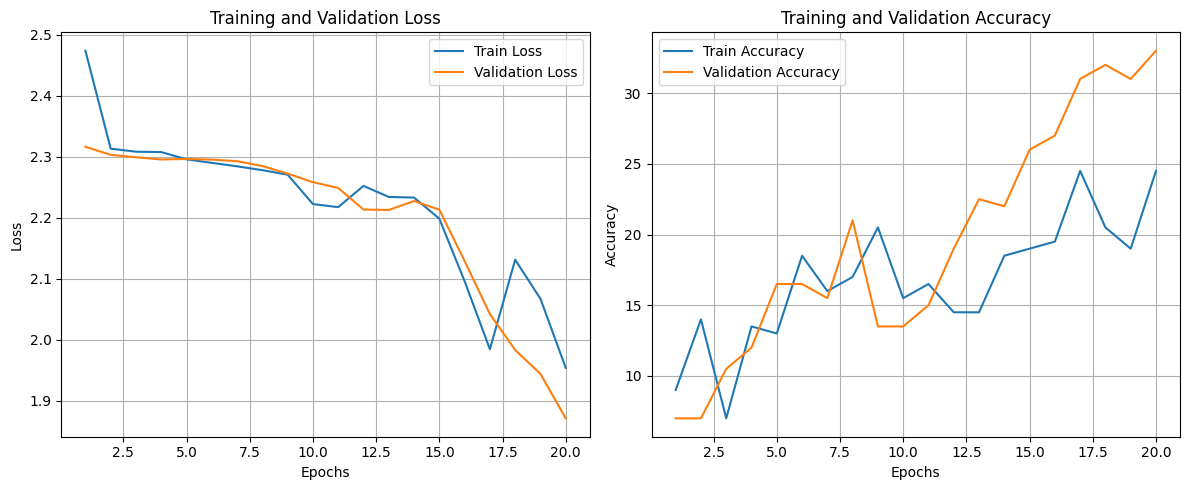

Acurácia final no conjunto de validação:
Acurácia da rede na base de teste: 33.00%

Treinando modelo com fc1_out=84


100%|██████████| 4/4 [00:00<00:00, 19.47it/s]


Epoch 1, Train Loss: 2.360, Train Accuracy: 10.00%
Epoch 1, Val Loss: 2.291, Val Accuracy: 18.00%


100%|██████████| 4/4 [00:00<00:00, 42.00it/s]


Epoch 2, Train Loss: 2.303, Train Accuracy: 8.50%
Epoch 2, Val Loss: 2.244, Val Accuracy: 27.50%


100%|██████████| 4/4 [00:00<00:00, 39.16it/s]


Epoch 3, Train Loss: 2.224, Train Accuracy: 23.50%
Epoch 3, Val Loss: 2.185, Val Accuracy: 26.00%


100%|██████████| 4/4 [00:00<00:00, 31.56it/s]

Epoch 4, Train Loss: 2.177, Train Accuracy: 25.00%


Epoch 4, Val Loss: 2.081, Val Accuracy: 36.00%


100%|██████████| 4/4 [00:00<00:00, 32.24it/s]

Epoch 5, Train Loss: 2.121, Train Accuracy: 37.00%


Epoch 5, Val Loss: 1.953, Val Accuracy: 44.00%


100%|██████████| 4/4 [00:00<00:00, 34.41it/s]

Epoch 6, Train Loss: 1.990, Train Accuracy: 37.50%


Epoch 6, Val Loss: 1.823, Val Accuracy: 40.00%


100%|██████████| 4/4 [00:00<00:00, 13.86it/s]


Epoch 7, Train Loss: 1.857, Train Accuracy: 36.50%
Epoch 7, Val Loss: 1.687, Val Accuracy: 42.50%


100%|██████████| 4/4 [00:00<00:00, 32.02it/s]


Epoch 8, Train Loss: 1.720, Train Accuracy: 39.00%
Epoch 8, Val Loss: 1.535, Val Accuracy: 50.50%


100%|██████████| 4/4 [00:00<00:00, 16.69it/s]


Epoch 9, Train Loss: 1.512, Train Accuracy: 48.50%
Epoch 9, Val Loss: 1.380, Val Accuracy: 55.00%


100%|██████████| 4/4 [00:00<00:00, 32.47it/s]


Epoch 10, Train Loss: 1.263, Train Accuracy: 50.00%
Epoch 10, Val Loss: 1.261, Val Accuracy: 52.50%


100%|██████████| 4/4 [00:00<00:00, 15.77it/s]


Epoch 11, Train Loss: 1.280, Train Accuracy: 51.00%
Epoch 11, Val Loss: 1.170, Val Accuracy: 54.00%


100%|██████████| 4/4 [00:00<00:00, 43.06it/s]


Epoch 12, Train Loss: 1.138, Train Accuracy: 54.00%
Epoch 12, Val Loss: 1.120, Val Accuracy: 57.50%


100%|██████████| 4/4 [00:00<00:00, 35.41it/s]


Epoch 13, Train Loss: 1.355, Train Accuracy: 52.00%
Epoch 13, Val Loss: 1.125, Val Accuracy: 57.00%


100%|██████████| 4/4 [00:00<00:00, 14.88it/s]


Epoch 14, Train Loss: 1.158, Train Accuracy: 55.50%
Epoch 14, Val Loss: 1.093, Val Accuracy: 62.50%


100%|██████████| 4/4 [00:00<00:00, 27.69it/s]

Epoch 15, Train Loss: 0.974, Train Accuracy: 62.50%


Epoch 15, Val Loss: 1.069, Val Accuracy: 65.50%


100%|██████████| 4/4 [00:00<00:00, 16.88it/s]


Epoch 16, Train Loss: 1.094, Train Accuracy: 61.00%
Epoch 16, Val Loss: 1.016, Val Accuracy: 64.50%


100%|██████████| 4/4 [00:00<00:00, 24.90it/s]


Epoch 17, Train Loss: 0.914, Train Accuracy: 66.00%
Epoch 17, Val Loss: 1.062, Val Accuracy: 61.50%


100%|██████████| 4/4 [00:00<00:00, 32.40it/s]


Epoch 18, Train Loss: 0.898, Train Accuracy: 64.00%
Epoch 18, Val Loss: 1.056, Val Accuracy: 59.50%


100%|██████████| 4/4 [00:00<00:00, 34.41it/s]


Epoch 19, Train Loss: 0.871, Train Accuracy: 69.00%
Epoch 19, Val Loss: 0.900, Val Accuracy: 66.50%


100%|██████████| 4/4 [00:00<00:00, 34.50it/s]

Epoch 20, Train Loss: 0.763, Train Accuracy: 71.50%


Epoch 20, Val Loss: 0.848, Val Accuracy: 71.00%
Treinamento concluído


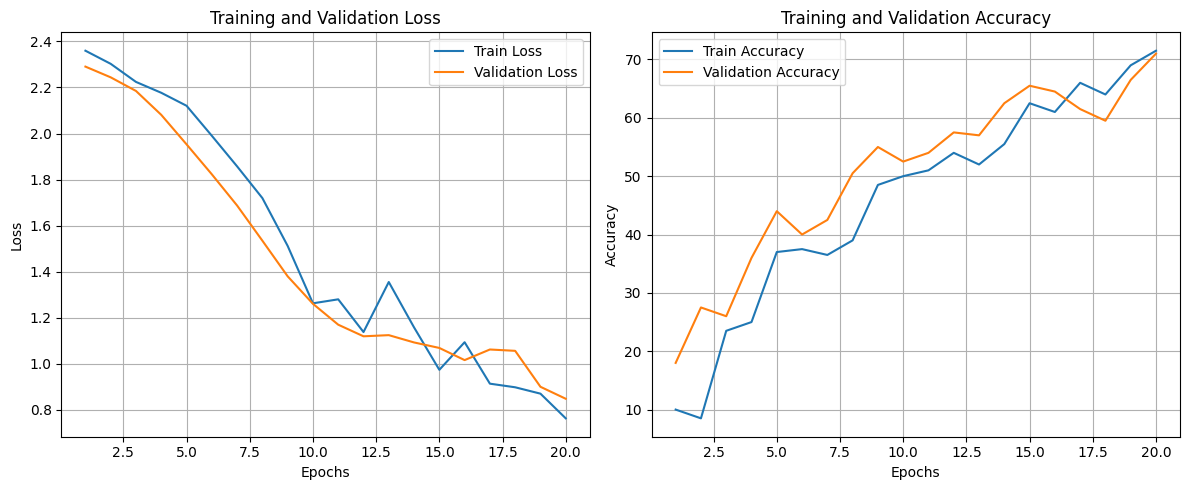

Acurácia final no conjunto de validação:
Acurácia da rede na base de teste: 71.00%

Resumo das melhores acurácias de validação para cada configuração de fc1_out:
fc1_out=25: 62.50%
fc1_out=13: 45.00%
fc1_out=65: 68.50%
fc1_out=12: 33.00%
fc1_out=84: 71.00%

O melhor valor de fc1_out é aquele que obteve a maior acurácia de validação final.


In [11]:
class CNNFlexibleFC(nn.Module):
    def __init__(self, conv1_out=6, conv2_out=12, fc1_out=64, dropout=0.2, initialize_weights=True):
        super().__init__()
        self.conv1 = nn.Conv2d(1, conv1_out, 5)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, 5)
        self.fc1 = nn.Linear(conv2_out * 4 * 4, fc1_out)
        self.fc2 = nn.Linear(fc1_out, 10)
        self.dropout = nn.Dropout(dropout)
        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.fc1.in_features)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

fc_results = {}
for i in range(5):
    fc1_out = np.random.randint(10, 100)
    print(f"\nTreinando modelo com fc1_out={fc1_out}")
    model = CNNFlexibleFC(conv1_out=conv1_out, conv2_out=conv2_out, fc1_out=fc1_out, dropout=0.5, initialize_weights=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    history = train_model(
        model=model,
        trainloader=train_loader,
        valloader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=20
    )
    plot_training_history(history)
    print("Acurácia final no conjunto de validação:")
    test_model(model, val_loader)
    fc_results[fc1_out] = history['val_accuracies'][-1]

print("\nResumo das melhores acurácias de validação para cada configuração de fc1_out:")
for k, v in fc_results.items():
    print(f"fc1_out={k}: {v:.2f}%")

print("\nO melhor valor de fc1_out é aquele que obteve a maior acurácia de validação final.")